## Udacity Data Wrangling & Analysing Project 
### Purpose of the Analysis
I will be wrangling ,analyzing and visualizing the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. 
### Sources of Data:
#### Enhanced Twitter Archive  
The WeRateDogs Twitter archive contains basic tweet data (tweet ID, timestamp, text, etc.) for all 5000+ of their tweets.This data is given as part of the project resources  
####  Image Predictions File 
The tweet image predictions file contains predictions for what breed of dog is present  in each tweet image according to neural network algorithm.The data of this file exists online in a url hosted in udacity and will be downloaded programatically using request api 
#### Twitter API    
Additional data can be retrieved from Twitter other than those exist in the enhanced twitter archive file ,like retweet and favorite counts.I will retrieve this data from the Twitter's API.

### Load Libraries

In [1]:
# importing required libraries 
import pandas as pd
import numpy as np
import requests
import tweepy
from tweepy import OAuthHandler
import json
import time
import os
import datetime
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns

### Gathering Data

#### Enhance Twitter Archive Data

In [2]:
twitter_archive_df = pd.read_csv('twitter-archive-enhanced.csv')


#### Image Predictions Data

In [3]:
# Downloading and saving the image prediction data using Requests
url ='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'

response = requests.get(url)
filename=url.split('/')[-1]

if not os.path.isfile(filename):
   with open(filename, 'wb') as file:
    file.write(response.content)
    
image_predictions_df  = pd.read_csv(filename, sep='\t')
df=pd.merge(image_predictions_df,twitter_archive_df,how='left',on='tweet_id')


In [4]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)
exp_tweet = api.get_status(twitter_archive_df.tweet_id[1000], tweet_mode = 'extended')
content = exp_tweet._json
#print(content)

In [6]:
errors = []
if not os.path.isfile('tweet_json.txt'):
# create the file and write on it
    with open ('tweet_json.txt', 'w') as file:
        for tweet_id in twitter_archive_df['tweet_id']:
            try:
                status = api.get_status(tweet_id, wait_on_rate_limit=True, wait_on_rate_limit_notify=True, tweet_mode =
                'extended')
                json.dump(status._json, file)
                file.write('\n')
            except Exception as e:
                print("Error on tweet id {}".format(tweet_id) + ";" + str(e))
                errors.append(tweet_id)
                

Error on tweet id 888202515573088257;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 873697596434513921;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 872668790621863937;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 872261713294495745;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 869988702071779329;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 866816280283807744;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 861769973181624320;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 856602993587888130;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 851953902622658560;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 845459076796616705;[{'code': 144, 'message': 'No status found with that ID.'}]
Error on tweet id 844704788403

#### Additional Data Via Twitter API

In [4]:
# extract data from tweet_json.txt file
tweets_list = []

with open('tweet_json.txt') as file:
    
    for line in file:
        tweet = json.loads(line)
        tweets_list.append({'tweet_id': tweet['id'],
                        'retweet_count': tweet['retweet_count'],
                        'favorite_count': tweet['favorite_count']})  

api_df=pd.DataFrame(tweets_list,columns=['tweet_id','retweet_count','favorite_count'])  


### Output Data Gathering
#### The 3 dataframes are:-
* twitter_archive_df - contains data read from provided csv file
* image_predictions_df - contains data read (by using requests) from tsv file hosted on server
* api_df - contains data obtained from twitter api

### Assessing Data

#### 1- Enhance Twitter Archive Data

In [10]:
twitter_archive_df.sample(5)

####  Quality
- Missing data in columns  doggo,floofer,pupper,puppo showing as "None"
- Missing data in several column

##### Tidy
- Column headers ( Doggo, Pepper , Pop)are values for a variable (dog_stage)



In [23]:
twitter_archive_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

#### Quality 
 - timestamp , retweeted_status_timestamp datatype is object instead of datetime
 - in_reply_to_status_id,in_reply_to_user_id datatype is float instead of integer
 - Missing values in columns  in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp
 - We only need original rating no retweet that have images should be included  - The variable "expanded_urls" has few missing values ,which means some records has no images, any raiting without images shouldn't be taken
    

In [11]:
twitter_archive_df['name'].value_counts()

#### Quality
- Missing data in column "name" are showed as  non-null values "None" 
- Incorrect values in column "name"  like a,an

In [16]:
twitter_archive_df['rating_numerator'].describe()

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64

In [5]:
twitter_archive_df['retweeted_status_id'].value_counts()

### 2-Images Predictions Data

In [35]:
image_predictions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


#### Quality
- The name of variables p1,p2,p3,p1_conf,p2_conf,p2_dog is not indicative 

## Cleaning Data

- Work on Copy of output of Data Gathering data frames

In [5]:
twitter_archive_clean = twitter_archive_df.copy()
image_predictions_clean = image_predictions_df.copy()
api_df_clean = api_df.copy()


**Quality Issue 1** 
- Keep Original ratings that have images (no retweet/no reply) in the 3 data frames (twitter_archive_clean,image_predictions_clean,api_df_clean)


In [6]:
#CODE: Delete retweets by filtering the NaN of retweeted_status_user_id
twitter_archive_clean = twitter_archive_clean[pd.isnull(twitter_archive_clean['retweeted_status_id'])]

#TEST
print(sum(twitter_archive_clean.retweeted_status_id.value_counts()))


0


In [7]:
#CODE: Delete retweets by filtering the NaN of in_reply_to_status_id
twitter_archive_clean = twitter_archive_clean[pd.isnull(twitter_archive_clean['in_reply_to_status_id'])]

#TEST
print(sum(twitter_archive_clean.in_reply_to_status_id.value_counts()))


0


In [8]:
#CODE: Delete Tweet with no images  by filtering the not is NAN of  expanded urls
twitter_archive_clean = twitter_archive_clean[pd.notnull(twitter_archive_clean['expanded_urls'])]

#TEST
print(sum(twitter_archive_clean.expanded_urls.value_counts()))

2094


- Keeping the original ratings tweets in archive data frame  will be completed when we select only the tweets that have image in the predictions dataframe

In [9]:
tweets_with_image = list(image_predictions_clean.tweet_id.unique())

In [10]:
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.tweet_id.isin(tweets_with_image)]

In [202]:
#TEST
twitter_archive_clean.info()

- Delete from image_predictions all tweets that are retweet or reply

In [11]:
#Code 
# Check the image_prediction table for extra tweet ids not in the archive table
np.logical_not(image_predictions_clean.tweet_id.isin(list(twitter_archive_clean.tweet_id)))

# Dropping the retweets and replies tweet ids from the image prediction dataframe
image_predictions_clean=image_predictions_clean[~np.logical_not(image_predictions_clean.tweet_id.isin(list(twitter_archive_clean.tweet_id)))]


In [203]:
#TEST
image_predictions_clean.info()

- Delete from twitter api  all tweets that are retweet or reply

In [12]:
#Code find all tweet that are in both image_predictions & twitter api
cond = api_df_clean['tweet_id'].isin(image_predictions_clean['tweet_id']) 
# Dropping the retweets and replies tweet ids from the tweet api dataframe
api_df_clean.drop(api_df_clean[~cond].index, inplace = True) 

In [204]:
#TEST
api_df_clean.info()

**Quality Issue 2** 
- Removing fields from tweet archive dataframe that will not be needed in the analysis

In [13]:
#CODE: Remove retweet , in reply to columns

twitter_archive_clean = twitter_archive_clean.drop(['in_reply_to_status_id','in_reply_to_user_id',
                                                    'retweeted_status_id',
                                                    'retweeted_status_user_id', 
                                                   'retweeted_status_timestamp', 
                                                    ], 1) 


In [205]:
#Test
list(twitter_archive_clean)

**Quality Issue 3** 
- Errorenous DataTypes in timestamp field in archive dataframe

In [14]:
#CODE: convert timestamp to datetime
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])
# Test
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null datetime64[ns]
source                1971 non-null object
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1971 non-null object
doggo                 1971 non-null object
floofer               1971 non-null object
pupper                1971 non-null object
puppo                 1971 non-null object
dtypes: datetime64[ns](1), int64(3), object(8)
memory usage: 200.2+ KB


**Quality Issue 4** 
- **Missing data in column "name" are showed as non-null values "None"**
- Change the name value to null or to the name value in "text" variable

**Quality Issue 5**
- **Incorrect values in column "name" like a,an,by**
- Change the name value to null or to the name value in "text" variable

- **Algorithm**
- Get dogs with "name" value less than 3 characters and start with lower case 
- Get dogs with "name" value="None
- Replace  the  name variable with the name found in "text" variable or replace it with null value 
- The dog name is found in the "text" variable using reqular expression.Searching for the pattern "named is ,"named"

In [15]:
# CODE: Replace incorect dog name variable with NaN or dog name if found in text variable
pattern= re.compile(r'(?:name(?:d)?)\s{1}(?:is\s)?(?:to\s)?([A-Za-z]+)')
for index, row in twitter_archive_clean.iterrows(): 
                    if (row['name'][0].islower() and len(row['name'])<3) or (row['name'] == 'None'):
                         try:
                          dog_name=re.findall(pattern, row['text'])[0] 
                                        #  +"##"+row['text'])
                          twitter_archive_clean.loc[index,'name'] = twitter_archive_clean.loc[index,'name'].replace(row['name'], dog_name)
                         except IndexError:
                             
                            twitter_archive_clean.loc[index,'name'] = np.nan

# Test           
twitter_archive_clean.name.value_counts(dropna = False)

NaN           557
Charlie        11
Oliver         10
Lucy           10
Cooper         10
Penny           9
Tucker          9
Sadie           8
Winston         8
Toby            7
Daisy           7
the             7
Lola            7
Koda            6
Bella           6
Jax             6
Stanley         6
Bo              6
Zoey            5
Scout           5
Dave            5
Buddy           5
Leo             5
Bailey          5
Milo            5
Louis           5
Chester         5
Oscar           5
Rusty           5
Bentley         4
             ... 
Lacy            1
Kanu            1
incredibly      1
Grizzwald       1
Kollin          1
Bronte          1
Mack            1
Dietrich        1
Jameson         1
Arlen           1
Marty           1
Julius          1
Ron             1
Sierra          1
Duddles         1
Dex             1
Jonah           1
Malikai         1
Johm            1
Maks            1
Joshwa          1
Gustaf          1
Asher           1
Kenny           1
Snickers  

**Quality Issue 6**
- Dog develepment category (puppo,floofer,doggo,pupper) in twitter archive dataframe have inconsistent presentation of null values as 'None' when Nan should be used

**Tiddiness Issue 1**
- Column headers ( Doggo, Pepper , Pop) in archive data frame  are values for a variable (dog_stage)


In [17]:
#CODE:
#1-Replace "None" values in columns (puppo,floofer,doggo,pupper) by empty string 
twitter_archive_clean.floofer.replace("None","",inplace=True)
twitter_archive_clean.puppo.replace("None","",inplace=True)
twitter_archive_clean.doggo.replace("None","",inplace=True)
twitter_archive_clean.pupper.replace("None","",inplace=True)

#2-Create new column dog_stage that concatenate the values in columns (puppo,floofer,doggo,pupper)-Tiddiness Issue 
twitter_archive_clean['dog_stage']=twitter_archive_clean.floofer+twitter_archive_clean.puppo +twitter_archive_clean.doggo+twitter_archive_clean.pupper
#3-drop old columns (puppo,floofer,doggo,pupper)
twitter_archive_clean.drop(columns=['floofer', 'puppo','doggo','pupper'])
#4-Remove inconsisteny in dog_breed presentation of null values as empty string- Quality Issue
twitter_archive_clean.dog_stage.replace("",np.nan,inplace=True)
#5-Entries that have two stages can be  separated by a hyphen for readability-Quality Issue
twitter_archive_clean.dog_stage.replace("doggopupper","doggo-pupper",inplace=True)
twitter_archive_clean.dog_stage.replace("flooferdoggo","floofer-doggo",inplace=True)
twitter_archive_clean.dog_stage.replace("puppodoggo","puppo-doggo",inplace=True)



In [19]:
#Test
twitter_archive_clean.dog_stage.value_counts(dropna=False)

**Quality Issue 7**
- Column names (p1,p2,p3) in Image Predictions Dataframe is not clear , change them to more readable names 

In [20]:
#CODE Rename Coloumn 
image_predictions_clean= image_predictions_clean.rename(columns={'p1':'prediction1','p2': 'prediction2','p3':'predictions3'
                                        })
image_predictions_clean= image_predictions_clean.rename(columns={'p1_conf':'confedince1','p2_conf': 'confedince2','p3_conf':'confedince3'
                                        })



In [14]:
# Test
image_predictions_clean.sample(5)

,tweet_id,jpg_url,img_num,Prediction1,confedince1,p1_dog,Prediction2,confedince2,p2_dog,Predictions3,confedince3,p3_dog
795,690938899477221376,https://pbs.twimg.com/media/CZa1QnSWEAAEOVr.jpg,1,geyser,0.370318,False,seashore,0.274888,False,beacon,0.046397,False
1200,740995100998766593,https://pbs.twimg.com/media/CkiLHCjUUAAPwUr.jpg,1,malamute,0.454363,True,Samoyed,0.215967,True,Siberian_husky,0.077500,True
865,697463031882764288,https://pbs.twimg.com/media/Ca3i7CzXIAMLhg8.jpg,1,Labrador_retriever,0.999885,True,golden_retriever,0.000098,True,pug,0.000008,True
1655,810284430598270976,https://pbs.twimg.com/media/Cz61ZD4W8AAcJEU.jpg,1,malamute,0.620768,True,Eskimo_dog,0.158395,True,Tibetan_mastiff,0.028962,True
831,693642232151285760,https://pbs.twimg.com/media/CaBP7i9W0AAJrIs.jpg,1,Scottish_deerhound,0.111893,True,bluetick,0.074302,True,German_short-haired_pointer,0.067000,True


**Quality Issue 8**

-Change the source of Tweet to more readable categories 
- <a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>
-<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a> 
- <a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>  
- <a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>  


In [21]:
twitter_archive_clean['source'] = twitter_archive_clean['source'].replace('<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'Twitter for iphone')
twitter_archive_clean['source'] =  twitter_archive_clean['source'].replace('<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
                                                                          'Vine - Make a Scene')
twitter_archive_clean['source'] =  twitter_archive_clean['source'].replace('<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
                                                                           'Twitter Web Client')
twitter_archive_clean['source'] =  twitter_archive_clean['source'].replace('<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>',
                                                                           'TweetDeck')



In [80]:
#Test
twitter_archive_clean['source'].value_counts()

Twitter for iphone    1932
Twitter Web Client      28
TweetDeck               11
Name: source, dtype: int64

**Tidiness issue 2**
- As Twitter API contains additional data about tweets than the original in Twitter Archive data frame they can be merged togather


In [22]:
#Code
twitter_df = pd.merge(twitter_archive_clean, api_df_clean, how = 'outer', on=['tweet_id'])

In [46]:
# Test 
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 19 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
retweet_count                 23

**Merging documents to form a master dataset**

In [23]:
twitter_df = pd.merge(twitter_df, image_predictions_clean, how = 'outer', on=['tweet_id'])

In [92]:
twitter_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1971 entries, 0 to 1970
Data columns (total 26 columns):
tweet_id              1971 non-null int64
timestamp             1971 non-null datetime64[ns]
source                1971 non-null object
text                  1971 non-null object
expanded_urls         1971 non-null object
rating_numerator      1971 non-null int64
rating_denominator    1971 non-null int64
name                  1414 non-null object
doggo                 1971 non-null object
floofer               1971 non-null object
pupper                1971 non-null object
puppo                 1971 non-null object
dog_breed             303 non-null object
retweet_count         1964 non-null float64
favorite_count        1964 non-null float64
jpg_url               1971 non-null object
img_num               1971 non-null int64
prediction1           1971 non-null object
confedince1           1971 non-null float64
p1_dog                1971 non-null bool
prediction2           1971 no

## Store##

In [24]:
twitter_df.to_csv('twitter_archive_master.csv',index=False)


# Visualize and Analyze#

In [25]:
# READ FROM MASTER DATASET
twitter_df = pd.read_csv('twitter_archive_master.csv')


In [37]:
twitter_df.timestamp=pd.to_datetime(twitter_df.timestamp)

**What is the most user source for posting Tweet?**

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

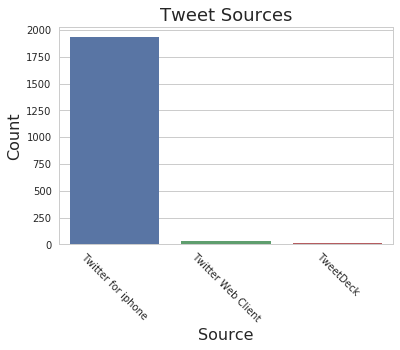

In [26]:
sorted_source = twitter_df['source'].value_counts().head(4).index
sns.set(style="whitegrid")
sns.countplot(data = twitter_df, x = 'source', order = sorted_source, orient = 'h')
plt.ylabel('Count', fontsize=16)
plt.xlabel('Source', fontsize=16)
plt.title('Tweet Sources',fontsize=18)
plt.xticks(rotation=-45)



**What is the  top 3 dog stages in the dataset?**

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

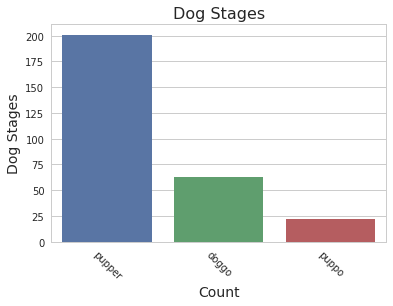

In [27]:
sorted_stage = twitter_df['dog_stage'].value_counts().head(3).index
sns.set(style="whitegrid")
sns.countplot(data = twitter_df, x = 'dog_stage', order = sorted_stage, orient = 'h')
plt.xlabel('Count', fontsize=14)
plt.ylabel('Dog Stages', fontsize=14)
plt.title('Dog Stages',fontsize=16)
plt.xticks(rotation=-45)

**What are  the top 10 Dog Breeds in the Data set?**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

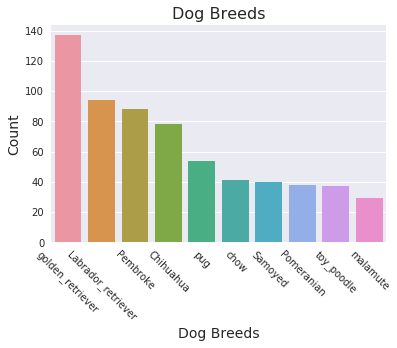

In [28]:
sorted_stage = twitter_df['prediction1'].value_counts().head(10).index
sns.set(style="darkgrid")
sns.countplot(data = twitter_df, x = 'prediction1', order = sorted_stage, orient = 'h')
plt.xlabel('Dog Breeds', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Dog Breeds',fontsize=16)
plt.xticks(rotation=-45)


**What is the relationship between favorite actions and retweet actions?**

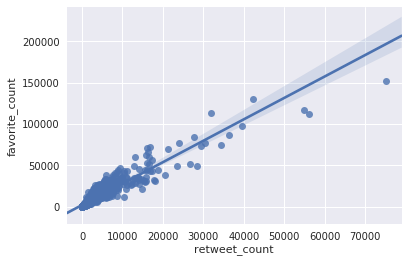

In [29]:
sns.regplot(x="retweet_count", y="favorite_count", data=twitter_df)

**What is the 10 top dog breeds in terms of average favorite count?**

Text(0.5,0,'Average Favorite Count')

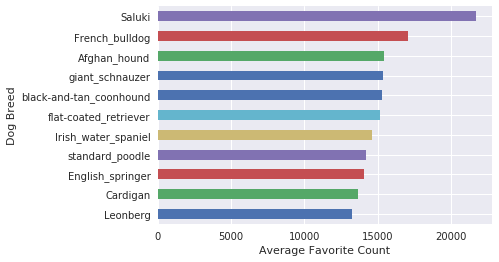

In [30]:
dog_fav_list=twitter_df[twitter_df.p1_dog==True].groupby(['prediction1']).favorite_count.mean().sort_values(ascending=False)[10::-1]
ax=dog_fav_list.plot(kind='barh')
ax.set_ylabel('Dog Breed')
ax.set_xlabel('Average Favorite Count')

#ax = sns.countplot(x=dog_fav_list.index,data=dog_fav_list)

**What is the top 10 dog breeds in terms of total favorite count?**

Text(0.5,0,'Total Favorite Count')

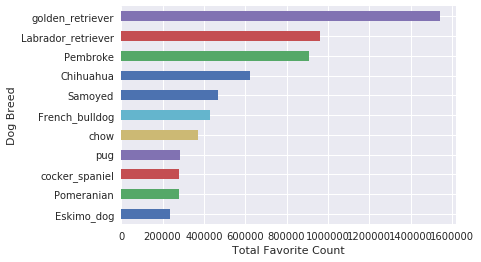

In [31]:
dog_fav_list=twitter_df[twitter_df.p1_dog==True].groupby(['prediction1']).favorite_count.sum().sort_values(ascending=False)[10::-1]
ax=dog_fav_list.plot(kind='barh')
ax.set_ylabel('Dog Breed')
ax.set_xlabel('Total Favorite Count')


**What is the Top Dog Stages in term of average favorite count?**

Text(0.5,0,'Average Favorite Count')

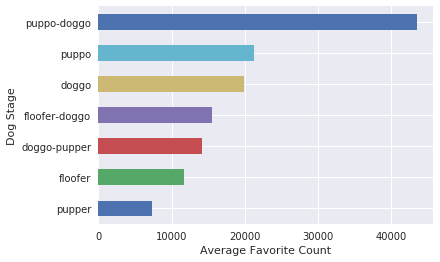

In [33]:
dog_fav_list=twitter_df[twitter_df.p1_dog==True].groupby(['dog_stage']).favorite_count.mean().sort_values(ascending=False)[10::-1]
ax=dog_fav_list.plot(kind='barh')
ax.set_ylabel('Dog Stage')
ax.set_xlabel('Average Favorite Count')

**What is the Average retweet count per day**

Text(0.5,0,'Average Retweet Count')

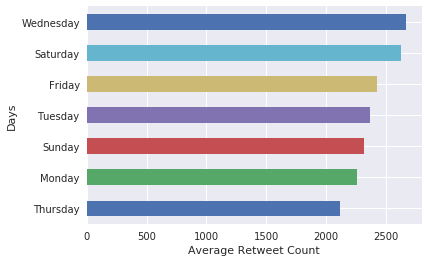

In [38]:
dog_fav_list=twitter_df.groupby(twitter_df['timestamp'].dt.day_name()).retweet_count.mean().sort_values(ascending=False)[7::-1]
ax=dog_fav_list.plot(kind='barh')
ax.set_ylabel('Days')
ax.set_xlabel('Average Retweet Count')